# Case study: HIV ritonavir clearance rate

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](preforming_regressions.ipynb).  The data used in this tutorial may be download [here](../data/hiv_data.csv).  This tutorial was developed in collaboration with Soichi Hirokawa.*

In [2]:
# In case someone is using Python 2...
from __future__ import division, print_function, unicode_literals, absolute_import

# The workhorses
import numpy as np
import pandas as pd
import emcee

# We'll use scipy.optimize.curve_fit to do the nonlinear regression
import scipy.optimize

# Plotting modules
import matplotlib.pyplot as plt

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

In this lesson, we will perform a nonlinear regression in order to estimate parameters describing clearance of HIV by the drug Ritonavir.  In working through this lesson, we will see some of the problems that may arise when using packages we did not write, and how to deal with them.

### HIV infection and clearance
A human immunodeficiency virus (HIV) is a virus that causes host organisms to develop a weaker, and sometimes ineffective, immune system. HIV inserts its viral RNA into a target cell of the immune system. This virus gets reverse transcribed into DNA and integrated into the host cell's chromosomes. The host cell will then transcribe the integrated DNA into mRNA for the production of viral proteins and produce new HIV. Newly created viruses then exit the cell by budding off from the host. HIV carries the danger of ongoing replication and cell infection without termination or immunological control. Because CD4 T cells, which communicate with other immune cells to activate responses to foreign pathogens, are the targets for viral infection and production, their infection leads to reductions in healthy CD4 T cell production, causing the immune system to weaken. This reduction in the immune response becomes particularly concerning after remaining infected for longer periods of time, leading to acquired immune deficiency syndrome (AIDS).

Some researchers have developed mathematical models to study HIV populations in the eukaryotic organisms. HIV-1 will infect cells at a rate $k$ and is produced from these infected T cells at a rate $p$. On the other hand, the viruses are lost due to clearance by the immune system of drugs, which occurs at a rate $c$, and infected cells die at a rate $\delta$ (Figure from Perelson, *Nat. Rev. Immunol.*, 2002)

![/Basic model of viral infection](hiv_figure.jpg "Basic model of viral infection Perelson Nat. Rev. Immunol. 2002)")

The above process can be written down as a system of differential equations.

\begin{align}
\frac{dT^*}{dt} &= k V_I T - \delta T^*\\[1em]
\frac{dV_I}{dt} &= -cV_I\\[1em]
\frac{dV_{NI}}{dt} &= N \delta T^{*} - c V_{NI},
\end{align}

Here, $T(t)$ is the number of uninfected T-cells at time $t$, and $T^*$ is the number of infected T cells. Furthermore, there is a concentration $V_I(t)$ of infectious viruses that infect T cells at the rate $k$.  We also have a concentration $V_{NI}$ of innocuous viruses. We define $N(t)$ to be the number of newly produced viruses from one infected cell over this cell's lifetime.  We can measure the total viral load, $V(t) = V_I(t) + V_{NI}(t)$.  If we initially have a viral load of $V(0) = V_0$, we can solve the system of differential equations to give

\begin{align}
V(t) = V_0e^{-ct} + \frac{cV_0}{c-\delta}\left[\frac{c}{c-\delta}(e^{-{\delta}t} - e^{-ct}) - {\delta}te^{-ct}\right].
\end{align}

We will take viral load data from a real patient and perform a regression to evaluate the parameters $c$ and $\delta$.  The drug Ritonavir is a protease inhibitor that serves to clear the viruses; i.e., it modulates $c$. So, $c$ is a good parameter to use to understand the efficacy of a drug.

### The data set
`Pandas` allows easy loading of the data set. Let's take a look.

In [3]:
# Load data set using Pandas
df = pd.read_csv('../data/hiv_data.csv', comment='#')

# Inspect
df

,Days after administration,RNA copies per mL
0,0.0000,106100.0
1,0.0831,93240.0
2,0.1465,166720.0
3,0.2587,153780.0
4,0.4828,118800.0
5,0.7448,116900.0
6,0.9817,109570.0
7,1.2563,111350.0
8,1.4926,74388.0
9,1.7299,83291.0


The column names, while descriptive, are cumbersome, so we will change them for ease of reference.  Specifically, we'll call them `time` and `viral load`.

In [4]:
# Rename columns
df.columns = ['time', 'viral load']

# Take a look
df

,time,viral load
0,0.0000,106100.0
1,0.0831,93240.0
2,0.1465,166720.0
3,0.2587,153780.0
4,0.4828,118800.0
5,0.7448,116900.0
6,0.9817,109570.0
7,1.2563,111350.0
8,1.4926,74388.0
9,1.7299,83291.0


That's better!  Now, let's make a plot.

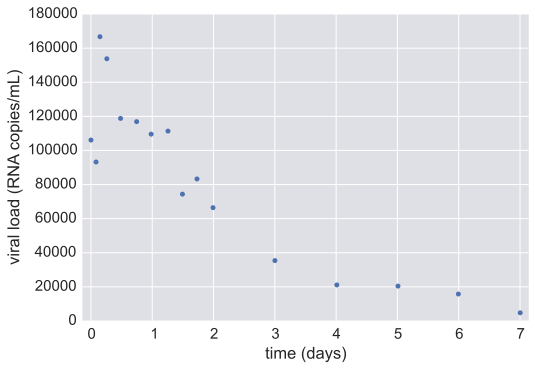

In [5]:
# Plot time versus viral load
plt.plot(df['time'], df['viral load'], '.', markersize=10)
plt.margins(x=0.02)
plt.xlabel('time (days)')
plt.ylabel('viral load (RNA copies/mL)')

### Defining the model function
We will use `scipy.optimize.curve_fit` to preform the regression.  Since this is our first time, let's read the doc string to figure out how to use it.

In [6]:
scipy.optimize.curve_fit?

We see that the function prototype is 

    scipy.optimize.curve_fit(f, xdata, ydata, p0=None)

and that `f` is the function we wish to use to fit our data.  The function `f` must have a prototype `f(t, *p)`, where the first parameter is the dependent variable and the remaining parameters are those to be determined by performing the regression.  So, our first step for using `scipy.optimize.curvefit` is to define the fit function `f`, which we will call `viral_load_model`.  We have three parameters, $V_0$, $c$, and $\delta$.

In [7]:
def viral_load_model_first_try(t, V_0, c, delta):
    """Viral load model given by Perelson et al."""
    
    bracket_term = c / (c - delta) * (np.exp(-delta * t) - np.exp(-c * t)) \
                                        - delta * t * np.exp(-c * t)
    return V_0 * (np.exp(-c * t) + c / (c - delta) * bracket_term)

There is a problem with this function.  When `c == delta`, we will get a divide-by-zero error!

In [8]:
bogus_viral_load = viral_load_model_first_try(3, 1e5, 1, 1)

ZeroDivisionError: division by zero

Of course, our unit tests would have uncovered this!  So, we need to put in a little logic to make sure that this divide by zero error does not happen.  We will use the fact that

\begin{align}
\lim_{c\to\delta} V(t) = V_0 \left(1 + \delta t + \frac{\delta^2 t^2}{2}\right)\mathrm{e}^{-\delta t}.
\end{align}

We can now write a function that handles the $c = \delta$ case.  We will also take care of the problem of non-physical values of the parameters.

In [9]:
def viral_load_model(t, V_0, c, delta):
    """Viral load model given by Perelson et al."""
    
    # Check to make sure all parameters are positive
    if np.any(t < 0) or np.any(np.array([V_0, c, delta]) < 0):
        raise ValueError('All parameters must be nonnegative.')
        
    # If c and d are close, use limiting expression
    if np.isclose(c, delta):
        return V_0 * (1 + delta * t +  (delta * t)**2 / 2) * np.exp(-delta * t)

    # Proceed with typical calculation
    bracket_term = c / (c - delta) * (np.exp(-delta * t) - np.exp(-c * t)) \
                                        - delta * t * np.exp(-c * t)
    return V_0 * (np.exp(-c * t) + c / (c - delta) * bracket_term)

### Performing the curve fit (first try)
With our fit function in place, we now need to supply initial guesses for the parameter values.   (We don't *have* to do this, but `scipy.optimize.curve_fit` will guess a value of 1 for all parameters, which is generally not a good idea.  You should always explicitly supply your own initial guesses.) In looking at the plot, $V_0 \approx 10^5$.  The viral load seems to decay on the time scale of a few days, so we will take $c \approx \delta \approx 0.3$ days$^{-1}$ as out initial guess.  Note that the initial guesses need to be passed as an array to `scipy.optimize.curvefit`.  The order of the guesses in the array is the same as the order in which the parameters are passed into the `viral_load_model` function.

In [10]:
# Specify initial guesses
V_0_guess = 1e5
c_guess = 0.3
delta_guess = 0.4

# Construct initial guess array
p0 = np.array([V_0_guess, c_guess, delta_guess])

When doing the curve fit, we see that it returns the optimal parameter values as well as an estimate of the covariance matrix.  For reasons I will not discuss here, this covariance matrix has some assumptions under the hood that are not always appropriate, so we will just ignore it.

Now we're ready to do the regression!

In [11]:
# Do curve fit, but dump covariance into dummy variable
p, _ = scipy.optimize.curve_fit(viral_load_model, df['time'], df['viral load'],
                                p0=p0)

# Print the results
print("""
V_0 = {0:.0f} RNA molecules / mL
  c = {1:.2f} 1/days
  δ = {2:.2f} 1/days
""".format(*tuple(p)))

ValueError: All parameters must be nonnegative.

Oh no!  We got an exception that we had nonnegative parameters!  This occurred because under the hood, `scipy.optimize.curve_fit` tries many sets of parameter values as it searches for those that bring the theoretical curve closest to the observed data.  (It is way more complicated than that, but we won't get into that here.)

### Performing the curve fit (second try)
At this point, we have a few options.
1. Take out our error checking on positivity of parameter.  The resulting curve with negative values of $c$ or $d$ will be so far off, the curve fit routine should come back toward physical parameter values after an excursion into non-physicality.
2. Try using something other than `curve_fit`.
3. Adjust our theoretical function by using the logarithm of the parameter values instead of the parameter values themselves.  This ensures that all parameter are positive.

I think option 1 is off the table.  We generally want to avoid "shoulds" when programming.  We do not want to just hope that the solver will work, even though nonphysical parameter values are encountered.

I prefer option 2.  We will not do this in the bootcamp, but I solve it using Markov chain Monte Carlo later.

We'll use option 3.  This still allows the solver to consider a smooth function of the parameter values.  So, let's define a function that takes the logarithms of the parameters and input.

In [12]:
def viral_load_model_log_params(t, log_V_0, log_c, log_delta):
    """Viral load model given by Perelson et al. with log parameters"""

    # Exponentiate parameters
    V_0, c, delta = np.exp(np.array([log_V_0, log_c, log_delta]))
    
    return viral_load_model(t, V_0, c, delta)

Now let's try our curve fit again.  We need to make sure we convert our initial guesses into logarithms.  Remember, now the solver will be working with logarithms of parameters.

In [13]:
# Specify initial guesses
log_V_0_guess = np.log(V_0_guess)
log_c_guess = np.log(c_guess)
log_delta_guess = np.log(delta_guess)

# Construct initial guess array
log_p0 = np.array([log_V_0_guess, log_c_guess, log_delta_guess])

# Do curve fit, but dump covariance into dummy variable
log_p, _ = scipy.optimize.curve_fit(viral_load_model_log_params, 
                                    df['time'], df['viral load'], p0=log_p0)

# Print the results
print("""
V_0 = {0:.0f} RNA molecules / mL
  c = {1:.2f} 1/days
  δ = {2:.2f} 1/days
""".format(*tuple(np.exp(log_p))))


V_0 = 128939 RNA molecules / mL
  c = 0.83 1/days
  δ = 6.95 1/days



### Parameter estimation using MCMC
We will now use the Markov chain Monte Carlo package `emcee` to do the regression.  We use a log posterior that is appropriate for unknown constant variance in measurements, the Student-t distribution.

In [14]:
# Define probability distribution to sample
def log_posterior(p, t, V):
    """Log of posterior probability for regression problem."""
    # All nonnegative parameteres
    if np.any(p < 0):
        return -np.inf
    
    # Unpack
    V_0, c, delta = p
    
    # Bound c and delta
    if c > 10 or delta > 10:
        return -np.inf
    
    return -len(V) / 2.0 * np.log(
        ((V - viral_load_model(t, V_0, c, delta))**2).sum())

# Set up MCMC parameters
n_dim = 3        # number of parameters in the model
n_walkers = 10   # number of MCMC walkers
n_burn = 10000     # "burn-in" period to let chains stabilize
n_steps = 50000   # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(1e5, 2e5, n_walkers)     # V_0
p0[:,1] = np.random.exponential(1.0, n_walkers)      # c
p0[:,2] = np.random.exponential(1.0, n_walkers)      # delta

# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                                args=(df['time'], df['viral load']), threads=6)

# Do the burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn)

# Reset sampler and run from the burn-in state we got to
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, n_steps)

We can now plot the posterior distribution based on our samples.  We'll do it with a scatter plot, plotting 1% of the points to keep the file size small.

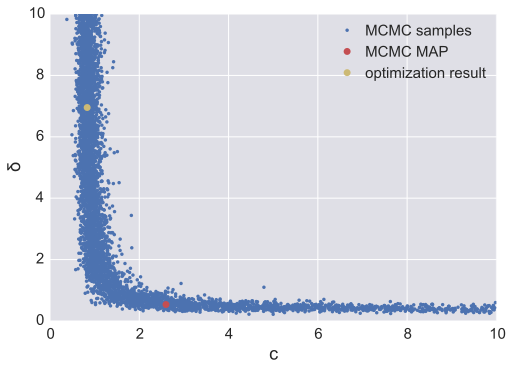

In [23]:
# Compute index of most probable parameter set
ind = np.nonzero(
    sampler.flatlnprobability == sampler.flatlnprobability.max())[0][0]

# Plot delta vs. c trace
plt.plot(sampler.flatchain[::100,1], sampler.flatchain[::100,2], '.', alpha=0.1)

# Plot most probable
plt.plot(sampler.flatchain[ind,1], sampler.flatchain[ind,2], 'o',
         color=sns.color_palette()[2])

# Plot what scipy.optimize.curvefit got
plt.plot(np.exp(log_p[1]), np.exp(log_p[2]), 'o', color=sns.color_palette()[4])

# Labeling
plt.xlabel('c', fontsize=18)
plt.ylabel('δ', fontsize=18)
plt.legend(('MCMC samples', 'MCMC MAP', 'optimization result'), loc='upper right')

We see that the posterior distribution has a strange shape, and that pretty much any of the parameter values along the stripe of high probability would fit the model.  Unless we had a good estimate for $\delta$ ahead of time, we cannot reliably parametrize $c$ from the experimental data alone.